# Motivation

&#9680; To understand the given dataset.

&#9680; To come up with a Machine Learning Problem Statement for the given dataset.

&#9680; State a Hypothesis on the Problem

&#9680; Preform Exploratory Data Analysis on the data

&#9680; Build a model to prove your hypothesis

&#9680; Evaluate and Report the results

# Load Libraries 

In [1]:
import pandas as pd
import numpy as np
import warnings
import os
import re
import math
import time
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import swifter
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import joblib
%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option('max_colwidth', 999)
pd.set_option('display.max_columns', 999)
pd.set_option("display.max_rows", 999)

In [19]:
import seaborn as sns

# Tools & Utilities 

In [6]:
import sklearn.metrics as metrics


def perf_measure(y_actual, y_pred):
    eval_dict = {}
    cm = metrics.confusion_matrix(y_actual, y_pred)
    TN = cm[0][0]
    TP = cm[1][1]
    FN = cm[1][0]
    FP = cm[0][1]
    prfs = metrics.precision_recall_fscore_support(y_actual, y_pred)
    eval_dict['Recall'] = [
        metrics.recall_score(y_actual, y_pred), prfs[1][0], prfs[1][1]
    ]
    eval_dict['Precision'] = [
        metrics.precision_score(y_actual, y_pred), prfs[0][0], prfs[0][1]
    ]
    eval_dict['False_Positive_Rate'] = [FP / prfs[3][0]]
    eval_dict['False_Negative_Rate'] = [FN / prfs[3][1]]
    eval_dict['F1_Score'] = [
        metrics.f1_score(y_actual, y_pred), prfs[2][0], prfs[2][1]
    ]
    eval_dict['Accuracy'] = [
        metrics.accuracy_score(y_actual, y_pred), TN / prfs[3][0],
        TP / prfs[3][1]
    ]
    eval_dict['Class_Count'] = [
        len(y_actual) / 100,
        len([i for i in y_actual if i in [0, 'clean']]) / 100,
        len([i for i in y_actual if i in [1, 'malicious']]) / 100
    ]
    eval_dict['Class_Ratio'] = [
        i / len(y_actual) for i in eval_dict['Class_Count']
    ]
    return pd.DataFrame(eval_dict, index=['Overall', 0, 1]) * 100

In [40]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(
        lat * 0.5)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5)**2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

In [76]:
def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(
        lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [77]:
from scipy.spatial import distance


def euclidean_distance(lat1, lng1, lat2, lng2):
    return distance.euclidean((lat1, lng1), (lat2, lng2))

# Load Data 

In [51]:
data_airport = pd.read_excel("3-1 to 3-31.xlsx")
data_drones_model = pd.read_excel("DJI Model Spreadsheet.xlsx")

In [5]:
print("data_airport shape",data_airport.shape)
display(data_airport.head())
print("data_drone shape",data_drones_model.shape)
display(data_drones_model.head())

data_airport shape (30669, 20)


,Detection Time,Aeroscope ID,Drone Type,Drone ID,Flight ID,Latitude,Longitude,Speed,Altitude,Northward Speed,Eastward Speed,Ascending Speed,Altitude/Height,Roll,Pitch,Yaw,Home Longitude,Home Latitude,Pilot Longitude,Pilot Latitude
0,2020-03-31 21:23:36,0QRDG810030067,Mavic Pro,08RDE9N00102SS,eb18b48d-b92a-4768-9449-4a9e8f7a3d8e,29.684525,-95.190142,14.347104,119.4,-2.37,-14.15,0,0,0.0,0.0,84.78,-95.191672,29.681099,-95.191770,29.681128
1,2020-03-31 21:23:30,0QRDG810030067,Mavic Pro,08RDE9N00102SS,eb18b48d-b92a-4768-9449-4a9e8f7a3d8e,29.684657,-95.189151,15.897553,119.3,-3.01,-15.61,0,0,0.0,0.0,81.99,-95.191672,29.681099,-95.191770,29.681128
2,2020-03-31 21:23:16,0QRDG810030067,Mavic Pro,08RDE9N00102SS,eb18b48d-b92a-4768-9449-4a9e8f7a3d8e,29.684943,-95.188544,14.563602,119.6,-11.52,-8.91,0,0,0.0,0.0,37.40,-95.191672,29.681099,-95.191775,29.681139
3,2020-03-31 21:22:56,0QRDG810030067,Mavic Pro,08RDE9N00102SS,eb18b48d-b92a-4768-9449-4a9e8f7a3d8e,29.685052,-95.189140,9.074365,122.5,3.04,8.55,0,0,0.0,0.0,242.45,-95.191672,29.681099,-95.191770,29.681139
4,2020-03-31 21:22:43,0QRDG810030067,Mavic Pro,08RDE9N00102SS,eb18b48d-b92a-4768-9449-4a9e8f7a3d8e,29.684680,-95.190211,10.414807,86.2,5.71,8.71,0,0,0.0,0.0,239.52,-95.191672,29.681099,-95.191770,29.681139


data_drone shape (56, 3)


,Product type,Drone name,Payload Capacity
0,0,unknown,NaN
1,1,Inspire 1,3.4 kg
2,2,P3P,1 kg
3,3,P3A,1.2 kg
4,4,P3S,1.6 kg


# Train of Thoughts 

&#9680; As we can observe the data with drones detection @ a certain US airport consist of geo-spatial information and other attributes.

&#9680; I perceive this problem statement as a <span style="color:red">**Risk Model**</span>.

&#9680; I will model a Logistic Regression model for predicting the risk associated to each drone detection where detection with high risk would require to take preventive measure at the airport's end.

&#9680; Primary Metric would be **"Precision"** as the model cannot afford to have high false positive rate because this will concur high cost @ business end and hence, model need to be very confident when predicting a detection as high risk event.

&#9680; Secondary Metric would be **F1-Score** such that we have a stable model.

&#9680; Response variable needs to be calculated based on the below logic :

    - Distance between the drone and the plane if it is > than a threshold we mark it as 1  else 0
    - 1 signifies **Threat** 0 means **No Threat**

# Assumptions

&#9680; Drone related information are under the following columns :
    
    - Detection Time
    - Drone Type
    - Latitude || Longitude || Altitude
    - Speed
    - Home Longitude || Home Latitude (are the information of drone's starting point)

&#9680; Airplane related information are under the following columns :

    - Northward Speed
    - Eastward Speed
    - Ascending Speed
    - Altitude/Height
    - Roll
    - Pitch
    - Yaw
    - Pilot Longitude || Pilot Latitude

&#9680; For missing values in Pilot's Longitude and Latitude value I assume that the plane is still in the hanger and has not let the ground || is still on the run-way.

&#9680; Distance values are on the same scale

# Data Understanding

## Data Pre-Processing 

### Analysis 

In [99]:
data_airport[data_airport.duplicated()].shape

(1961, 27)

In [100]:
(data_airport[data_airport.duplicated()].shape[0]/data_airport.shape[0])*100

6.396998858261295

In [11]:
data_airport.isnull().sum()

Detection Time      0
Aeroscope ID        0
Drone Type          0
Drone ID            0
Flight ID           0
Latitude            0
Longitude           0
Speed               0
Altitude            0
Northward Speed     0
Eastward Speed      0
Ascending Speed     0
Altitude/Height     0
Roll                0
Pitch               0
Yaw                 0
Home Longitude      0
Home Latitude       0
Pilot Longitude    14
Pilot Latitude     14
dtype: int64

In [14]:
data_airport.dropna(inplace=True)

<AxesSubplot:>

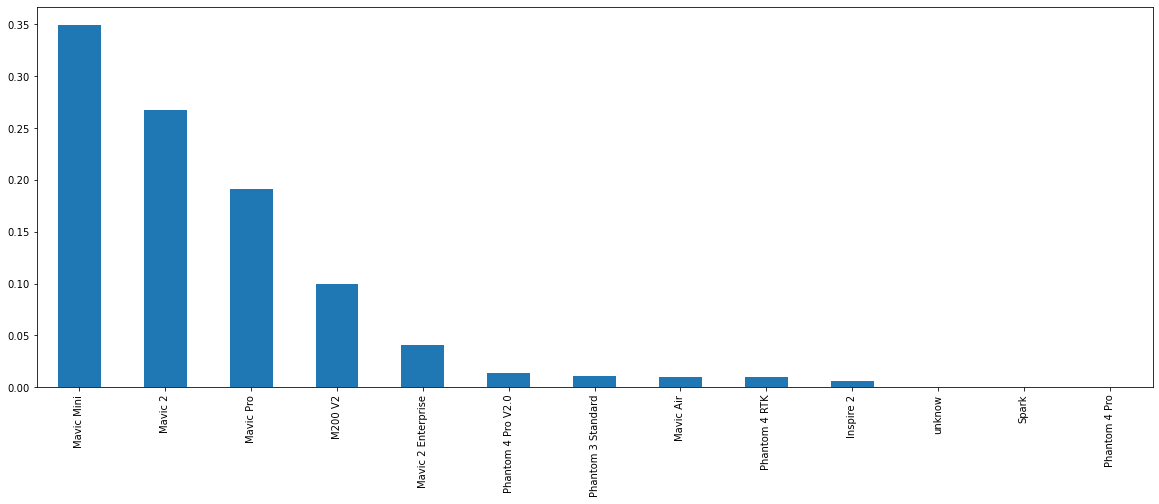

In [32]:
data_airport['Drone Type'].fillna('missing').value_counts(normalize=True).plot(kind='bar',figsize=(20,7))

In [26]:
data_airport = pd.merge(data_airport,
                        data_drones_model,
                        left_on='Drone Type',
                        right_on='Drone name',
                        how='left',
                        indicator=True)

In [27]:
data_airport.shape

(30655, 24)

In [30]:
data_airport._merge.value_counts()

both          29557
left_only      1098
right_only        0
Name: _merge, dtype: int64

In [38]:
data_airport.isnull().sum()

Detection Time         0
Aeroscope ID           0
Drone Type             0
Drone ID               0
Flight ID              0
Latitude               0
Longitude              0
Speed                  0
Altitude               0
Northward Speed        0
Eastward Speed         0
Ascending Speed        0
Altitude/Height        0
Roll                   0
Pitch                  0
Yaw                    0
Home Longitude         0
Home Latitude          0
Pilot Longitude        0
Pilot Latitude         0
Product type        1098
Drone name          1098
Payload Capacity       0
_merge                 0
dtype: int64

In [33]:
data_airport['Drone Type'].fillna('missing').value_counts(normalize=True)

Mavic Mini            0.349535
Mavic 2               0.267232
Mavic Pro             0.191355
M200 V2               0.099266
Mavic 2 Enterprise    0.040679
Phantom 4 Pro V2.0    0.013929
Phantom 3 Standard    0.010961
Mavic Air             0.010210
Phantom 4 RTK         0.010015
Inspire 2             0.005643
unknow                0.000750
Spark                 0.000261
Phantom 4 Pro         0.000163
Name: Drone Type, dtype: float64

In [36]:
data_airport['Drone Type'].replace("unknow","unknown",inplace=True)
data_airport['Payload Capacity'].fillna(-99,inplace=True)

In [37]:
data_airport[data_airport._merge=='left_only']['Drone Type'].value_counts()

Phantom 4 Pro V2.0    427
Phantom 3 Standard    336
Phantom 4 RTK         307
unknown                23
Phantom 4 Pro           5
Name: Drone Type, dtype: int64

In [48]:
data_airport.dtypes

Detection Time        object
Aeroscope ID          object
Drone Type            object
Drone ID              object
Flight ID             object
Latitude             float64
Longitude            float64
Speed                float64
Altitude             float64
Northward Speed      float64
Eastward Speed       float64
Ascending Speed        int64
Altitude/Height        int64
Roll                 float64
Pitch                float64
Yaw                  float64
Home Longitude       float64
Home Latitude        float64
Pilot Longitude      float64
Pilot Latitude       float64
Product type         float64
Drone name            object
Payload Capacity      object
_merge              category
dtype: object

In [49]:
data_airport.select_dtypes('float').columns

Index(['Latitude', 'Longitude', 'Speed', 'Altitude', 'Northward Speed',
       'Eastward Speed', 'Roll', 'Pitch', 'Yaw', 'Home Longitude',
       'Home Latitude', 'Pilot Longitude', 'Pilot Latitude', 'Product type'],
      dtype='object')

In [43]:
data_airport[data_airport.select_dtypes('float').columns].describe()

,Latitude,Longitude,Speed,Altitude,Northward Speed,Eastward Speed,Roll,Pitch,Yaw,Home Longitude,Home Latitude,Pilot Longitude,Pilot Latitude,Product type
count,30655.000000,30655.000000,30655.000000,30655.000000,30655.000000,30655.000000,30655.000000,30655.000000,30655.000000,30655.000000,30655.000000,30655.000000,30655.000000,29557.000000
mean,29.661121,-95.024241,3.380757,56.071992,0.091097,-0.102916,0.006364,-0.055450,178.565042,-93.965770,29.330855,-42.609095,19.841712,40.793484
std,0.944430,3.023748,4.504601,50.228737,3.447946,4.451303,0.836558,1.304966,102.443964,10.414861,3.251109,47.308435,13.975576,13.707377
min,0.000000,-95.430848,0.000000,-2.300000,-18.050000,-22.490000,-18.620000,-30.120000,0.010000,-95.432395,0.000000,-95.418203,0.000000,16.000000
25%,29.671846,-95.145068,0.070711,24.900000,-0.160000,-0.270000,0.000000,0.000000,89.860000,-95.145234,29.666603,-95.127449,0.000000,41.000000
50%,29.695589,-95.121491,1.136354,40.100000,0.000000,0.000000,0.000000,0.000000,179.100000,-95.120998,29.695606,0.000000,29.665360,44.000000
75%,29.702550,-95.092545,5.308738,72.400000,0.200000,0.140000,0.000000,0.000000,266.870000,-95.092115,29.702556,0.000000,29.697463,53.000000
max,29.929361,0.000000,27.697628,499.000000,27.690000,21.630000,25.030000,22.220000,359.990000,0.000000,29.929281,0.000000,29.830750,53.000000


<AxesSubplot:>

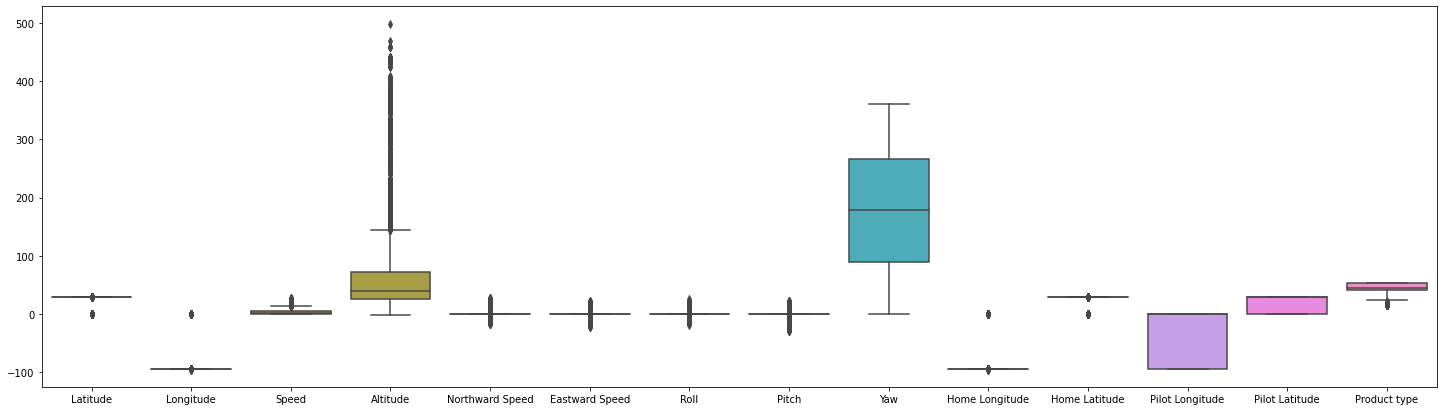

In [47]:
plt.figure(figsize=(25,7))
sns.boxplot(data = data_airport[data_airport.select_dtypes('float').columns])

### Pre-Processing Steps

In [52]:
data_airport = data_airport[~data_airport.duplicated()].copy(deep=True)
data_airport.dropna(inplace=True)
data_airport['Drone Type'].replace("unknow", "unknown", inplace=True)
data_airport = pd.merge(data_airport,
                        data_drones_model,
                        left_on='Drone Type',
                        right_on='Drone name',
                        how='left',
                        indicator=True)

data_airport['Payload Capacity'].fillna(-99, inplace=True)
data_airport['Detection Time'] = data_airport['Detection Time'].astype('datetime64[ns]')

### Noted-Points 

    - ~ 6.4% records are duplicate I will drop them from analysis 
    - As, we can see there are 14 records (i.e. ~0.46%) for which the Pilot's longitude and latitude values are missing
    - As, I have the business context missing I choose to drop them from my analysis.
    - as we can see there is certainly a typo in the Drone Type columns as I expect the value to be "Unknown" but it is 
      miss-spelled as "unknow"
    - for drones where we don't have the payload value I will replace it with -99 for the model to understand it as 
      separate category because intuitively it would mean more risk   
    - also, the drone model table is not up-to date as there are some names in the current data but is missing from the 
      drone make and manufacture data 
    - we can see certain drone flying at higher altitudes 

## Exploratory Data Analysis 

### Response Creation

In [56]:
data_airport['great_circle_distance'] = data_airport[[
    'Latitude', 'Longitude', 'Pilot Latitude', 'Pilot Longitude'
]].swifter.apply(lambda x: haversine_array(x[0],x[1],x[2],x[3]),axis=1)

<AxesSubplot:xlabel='great_circle_distance', ylabel='Count'>

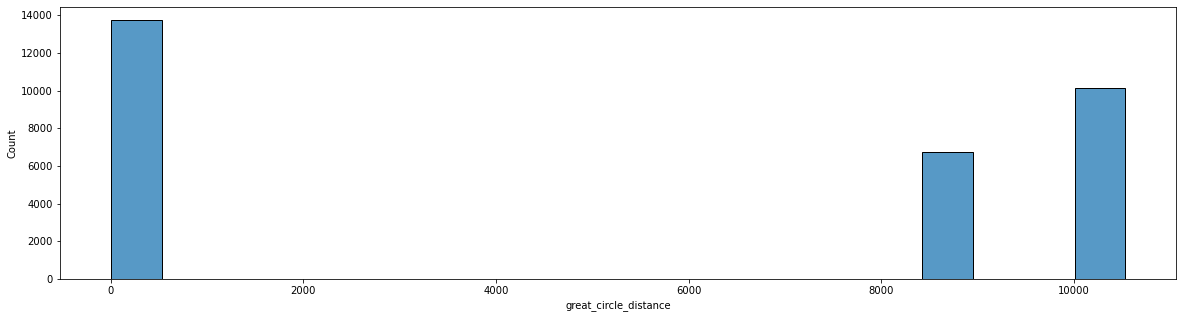

In [62]:
plt.figure(figsize=(20,5))
sns.histplot(data_airport['great_circle_distance'],bins=20)

    - we can see as expected there are clear blob showing drones which are flying close to the aircraft posing high risk.

<AxesSubplot:ylabel='Count'>

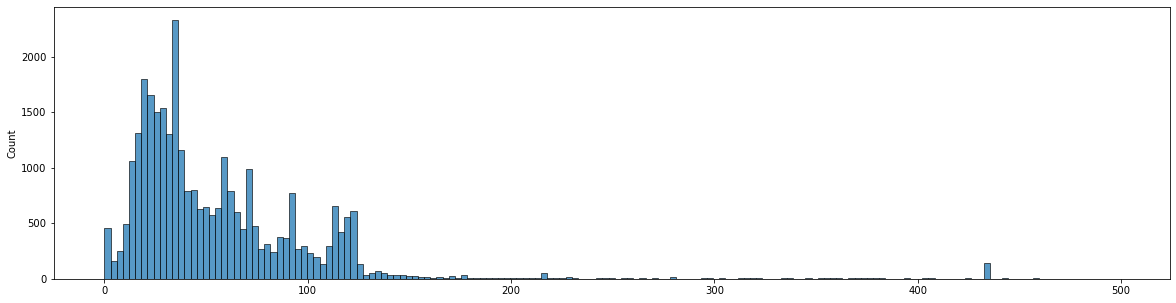

In [68]:
plt.figure(figsize=(20, 5))
sns.histplot(data_airport[['Altitude', 'Altitude/Height'
                           ]].swifter.apply(lambda x: abs(x[0] - x[1]),
                                            axis=1))

In [69]:
data_airport['absolute_altitude_difference'] = data_airport[['Altitude', 'Altitude/Height'
                                                             ]].swifter.apply(lambda x: abs(x[0] - x[1]),
                                                                              axis=1)

<AxesSubplot:>

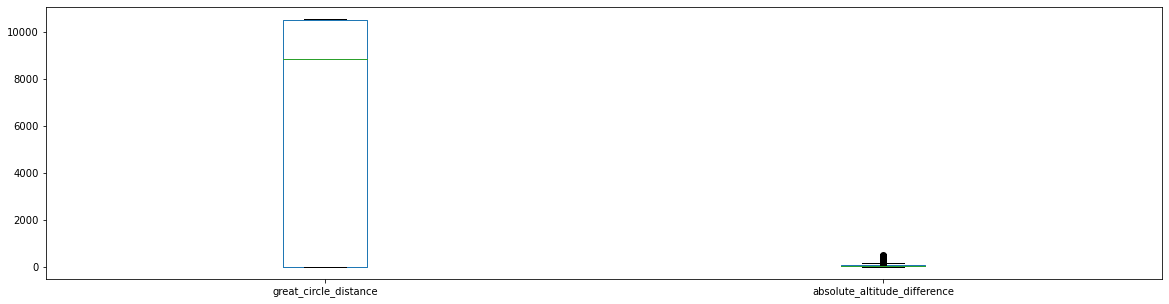

In [70]:
data_airport[['great_circle_distance','absolute_altitude_difference']].plot(kind='box',figsize=(20,5))

In [75]:
data_airport[['great_circle_distance', 'absolute_altitude_difference'
              ]].apply(lambda x: 1 if (x[0] < 2000) & (x[1] < 50) else 0,
                       axis=1).value_counts()

0    23650
1     7005
dtype: int64

In [86]:
data_airport['Target'] = data_airport[[
    'great_circle_distance', 'absolute_altitude_difference'
]].apply(lambda x: 1 if (x[0] <= 2000) & (x[1] <= 50) else 0, axis=1)

In [87]:
data_airport['Target'].value_counts()

0    23636
1     7019
Name: Target, dtype: int64

    - I will tag use the above condition to mark the label for each detection as 1 or 0 
    - 1 corresponds to risk and 0 as no-risk
    - Will train a model to predict the risk probability for un-seen drone detection
    - I could introduce some noise in the labeling as we will be using these logic for labeling as features in the model, but for the shake of simplicity I will skip this.

### Analysis for Potential Features || Pattern : (Uni-variate Analysis)

<AxesSubplot:>

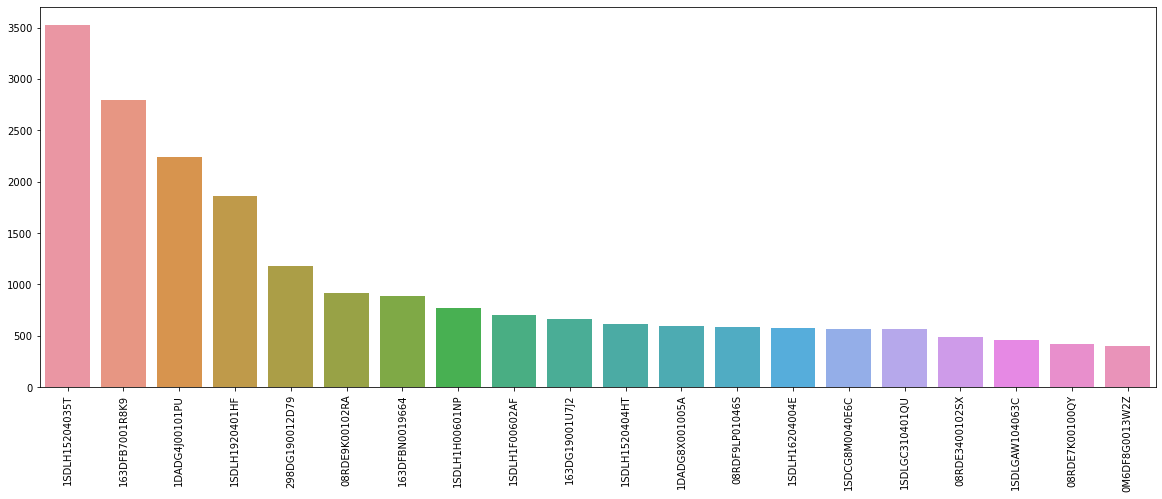

In [97]:
plt.figure(figsize=(20, 7))
plt.xticks(rotation=90)
sns.barplot(x=data_airport['Drone ID'].value_counts().index[:20],
            y=data_airport['Drone ID'].value_counts().values[:20])

    - we can see some drones have been detected quite frequently.

<AxesSubplot:>

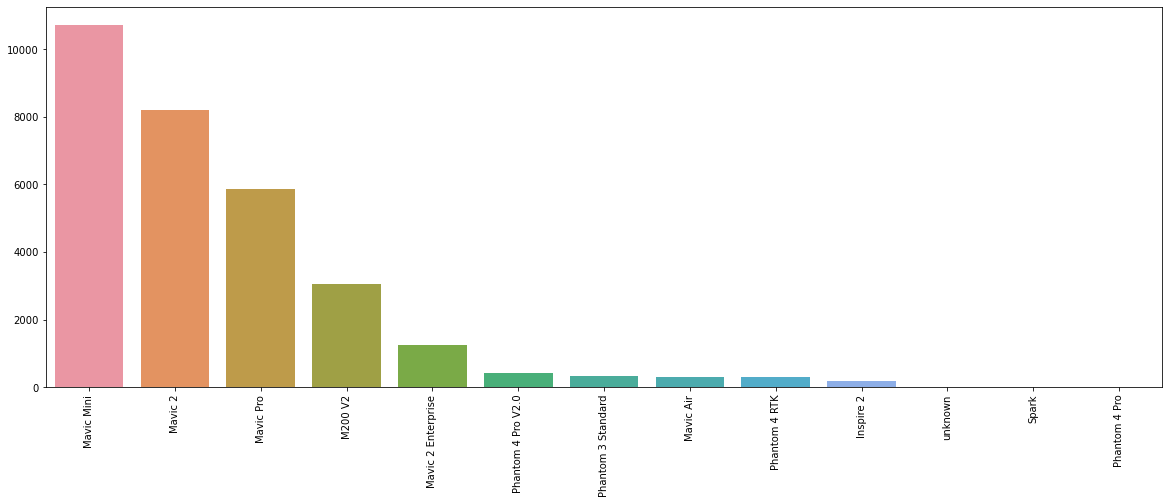

In [98]:
plt.figure(figsize=(20, 7))
plt.xticks(rotation=90)
sns.barplot(x=data_airport['Drone Type'].value_counts().index[:20],
            y=data_airport['Drone Type'].value_counts().values[:20])

<AxesSubplot:>

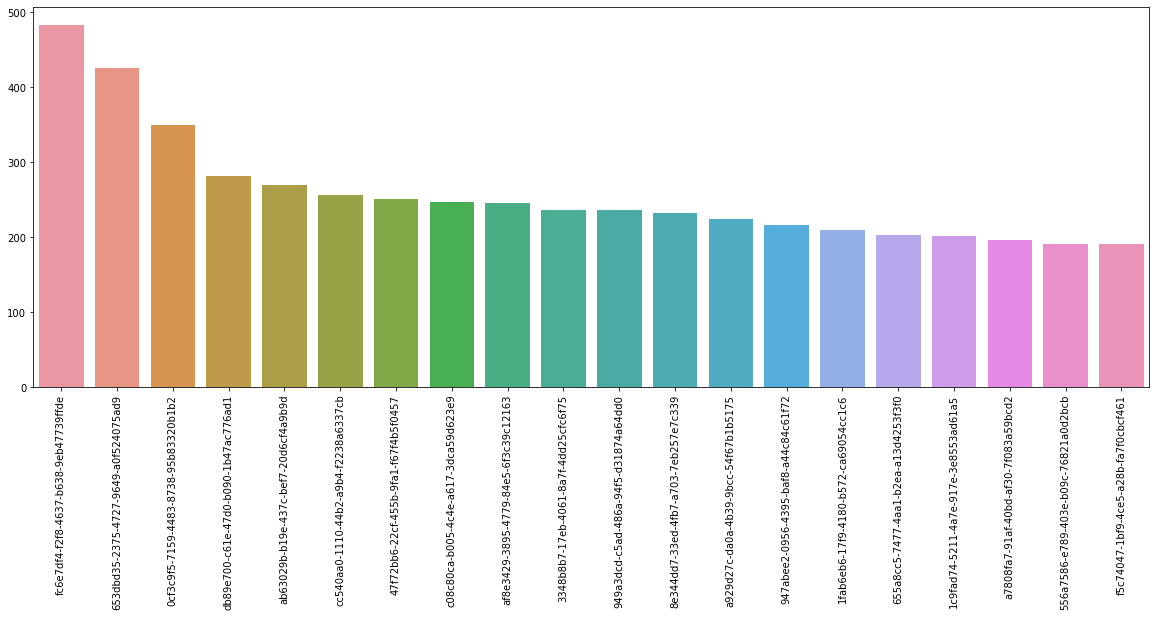

In [101]:
plt.figure(figsize=(20, 7))
plt.xticks(rotation=90)
sns.barplot(x=data_airport['Flight ID'].value_counts().index[:20],
            y=data_airport['Flight ID'].value_counts().values[:20])

<AxesSubplot:>

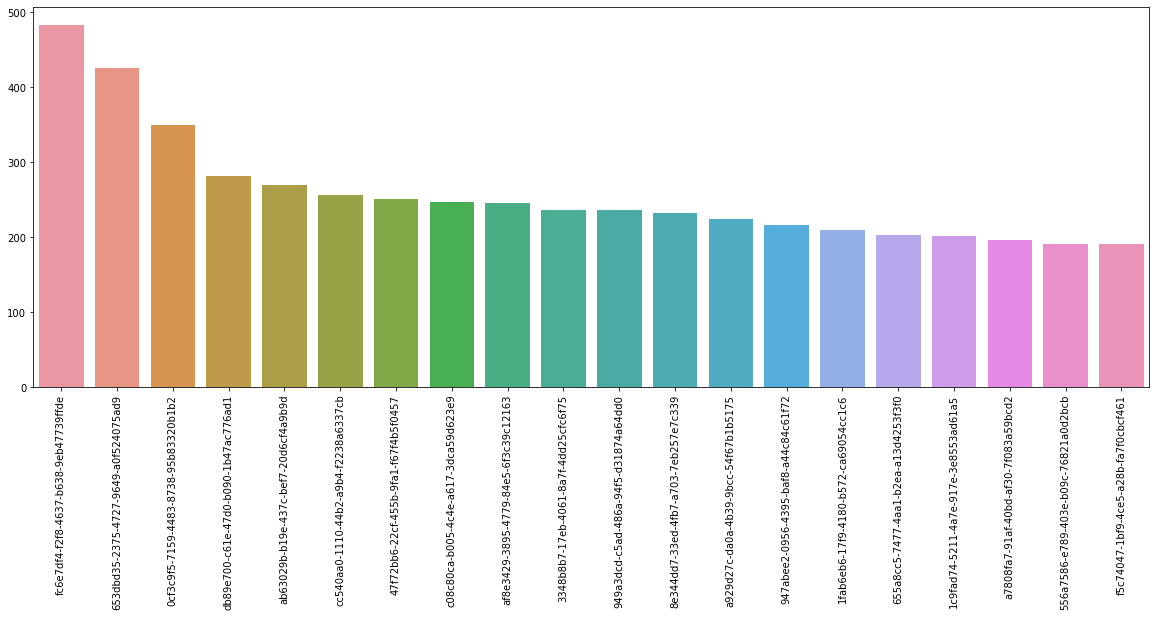

In [101]:
plt.figure(figsize=(20, 7))
plt.xticks(rotation=90)
sns.barplot(x=data_airport['Flight ID'].value_counts().index[:20],
            y=data_airport['Flight ID'].value_counts().values[:20])

### Time Analysis 

In [109]:
data_airport['Detection Time'] = data_airport['Detection Time'].astype('datetime64[ns]')

In [111]:
pd.crosstab(data_airport['Detection Time'].dt.hour,data_airport['Target'])

Target,0,1
Detection Time,,
0,61,1
1,556,0
2,264,32
3,158,124
6,87,0
7,598,105
8,615,153
9,1739,404
10,2018,346


    - We can see the risk is spread across all the time of the day

<AxesSubplot:ylabel='Density'>

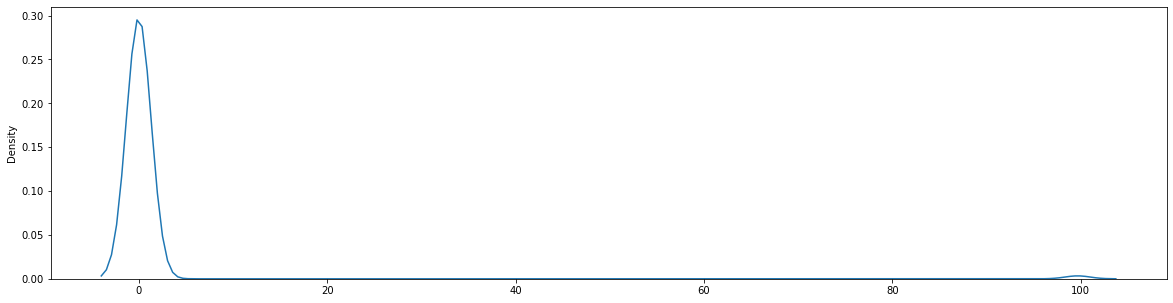

In [105]:
plt.figure(figsize=(20, 5))
sns.kdeplot(data_airport[[
    'Latitude', 'Longitude', 'Home Latitude', 'Home Longitude'
]].swifter.apply(lambda x: euclidean_distance(x[0],x[1],x[2],x[3]),axis=1))

# Feature Engineering 

In [118]:
feature_df = pd.DataFrame()

## Time Based Features 

In [112]:
feature_df['Day_or_Night'] = data_airport['Detection Time'].dt.hour.apply(
    lambda x: 1 if x in [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18] else 0)
feature_df['Hour_of_Day'] = data_airport['Detection Time'].dt.hour

## Based on Drone Profile 

In [120]:
feature_df['profiled_count'] = pd.merge(
    data_airport['Drone ID'],
    data_airport['Drone ID'].value_counts().reset_index(),
    left_on='Drone ID',
    right_on='index',
    how='inner')['Drone ID_y']

## Distance Based Features 

In [ ]:
feature_df['bearing_drone_flight'] = data_airport[[
    'Latitude', 'Longitude', 'Pilot Latitude', 'Pilot Longitude'
]].swifter.apply(lambda x: bearing_array(x[0], x[1], x[2], x[3]), axis=1)
feature_df['great_circle_distance'] = data_airport[[
    'Latitude', 'Longitude', 'Pilot Latitude', 'Pilot Longitude'
]].swifter.apply(lambda x: haversine_array(x[0], x[1], x[2], x[3]), axis=1)
feature_df['BVLOS'] = data_airport[[
    'Latitude', 'Longitude', 'Home Latitude', 'Home Longitude'
]].swifter.apply(lambda x: euclidean_distance(x[0], x[1], x[2], x[3]),
                 axis=1).apply(lambda x: 1 if x >= 10 else 0)
feature_df['abs_altitude_difference'] = data_airport[[
    'Altitude', 'Altitude/Height'
]].swifter.apply(lambda x: abs(x[0] - x[1]), axis=1)

In [124]:
feature_df['time_to_colide'] = data_airport[[
    'Speed', 'great_circle_distance', 'Ascending Speed'
]].apply(lambda x: x[1] / (x[0] - x[2]) + 1, axis=1)

## Drone Based Features 

In [128]:
feature_df['Payload Capacity'] = data_airport['Payload Capacity'].apply(
    lambda x: float(str(x).split()[0]))

In [ ]:
feature_df['Unknown_Drone'] = data_airport['Drone Type'].apply(
    lambda x: 1 if str(x) =='unknown' else 0)

In [129]:
feature_df['Product type'] = data_airport['Product type'].fillna(-99).apply(int)

## Rest Raw Fields as-is 

In [130]:
for i in [
    'Latitude', 'Longitude', 'Speed', 'Altitude', 'Northward Speed',
    'Eastward Speed', 'Ascending Speed', 'Altitude/Height', 'Roll', 'Pitch',
    'Yaw', 'Home Longitude', 'Home Latitude', 'Pilot Longitude',
    'Pilot Latitude'
]:
    feature_df[i] = data_airport[i].tolist().copy()
del i

In [ ]:
data_airport['great_circle_distance'] = data_airport[[
    'Latitude', 'Longitude', 'Pilot Latitude', 'Pilot Longitude'
]].swifter.apply(lambda x: haversine_array(x[0],x[1],x[2],x[3]),axis=1)

99.743117      1
99.742692      1
99.742425      2
99.742423      5
99.742422      2
            ... 
0.000006      62
0.000006       8
0.000006      58
0.000006      22
0.000000     369
Length: 19727, dtype: int64

In [113]:
data_airport['Aeroscope ID'].nunique()

1

In [ ]:
data_airport['euclidean_distance'] = 

In [123]:
data_airport.head()

,Detection Time,Aeroscope ID,Drone Type,Drone ID,Flight ID,Latitude,Longitude,Speed,Altitude,Northward Speed,Eastward Speed,Ascending Speed,Altitude/Height,Roll,Pitch,Yaw,Home Longitude,Home Latitude,Pilot Longitude,Pilot Latitude,Product type,Drone name,Payload Capacity,_merge,great_circle_distance,absolute_altitude_difference,Target,Day_or_Night,Hour_of_Day
0,2020-03-31 21:23:36,0QRDG810030067,Mavic Pro,08RDE9N00102SS,eb18b48d-b92a-4768-9449-4a9e8f7a3d8e,29.684525,-95.190142,14.347104,119.4,-2.37,-14.15,0,0,0.0,0.0,84.78,-95.191672,29.681099,-95.191770,29.681128,16.0,Mavic Pro,0.8 kg,both,0.409198,119.4,0,0,21
1,2020-03-31 21:23:30,0QRDG810030067,Mavic Pro,08RDE9N00102SS,eb18b48d-b92a-4768-9449-4a9e8f7a3d8e,29.684657,-95.189151,15.897553,119.3,-3.01,-15.61,0,0,0.0,0.0,81.99,-95.191672,29.681099,-95.191770,29.681128,16.0,Mavic Pro,0.8 kg,both,0.466908,119.3,0,0,21
2,2020-03-31 21:23:16,0QRDG810030067,Mavic Pro,08RDE9N00102SS,eb18b48d-b92a-4768-9449-4a9e8f7a3d8e,29.684943,-95.188544,14.563602,119.6,-11.52,-8.91,0,0,0.0,0.0,37.40,-95.191672,29.681099,-95.191775,29.681139,16.0,Mavic Pro,0.8 kg,both,0.525747,119.6,0,0,21
3,2020-03-31 21:22:56,0QRDG810030067,Mavic Pro,08RDE9N00102SS,eb18b48d-b92a-4768-9449-4a9e8f7a3d8e,29.685052,-95.189140,9.074365,122.5,3.04,8.55,0,0,0.0,0.0,242.45,-95.191672,29.681099,-95.191770,29.681139,16.0,Mavic Pro,0.8 kg,both,0.503875,122.5,0,0,21
4,2020-03-31 21:22:43,0QRDG810030067,Mavic Pro,08RDE9N00102SS,eb18b48d-b92a-4768-9449-4a9e8f7a3d8e,29.684680,-95.190211,10.414807,86.2,5.71,8.71,0,0,0.0,0.0,239.52,-95.191672,29.681099,-95.191770,29.681139,16.0,Mavic Pro,0.8 kg,both,0.421530,86.2,0,0,21


# Feature Selection

# Data Splitting

# Model Training & Tuning 

# Model Evaluation

# Model Explanation